# CNN Regression

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
df = pd.read_csv("../dataset/abalone.csv",index_col=0)

In [43]:
# 데이터 확인
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9


In [45]:
# 컬렴명 확인
df.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

Text(0.5, 1.0, 'Label')

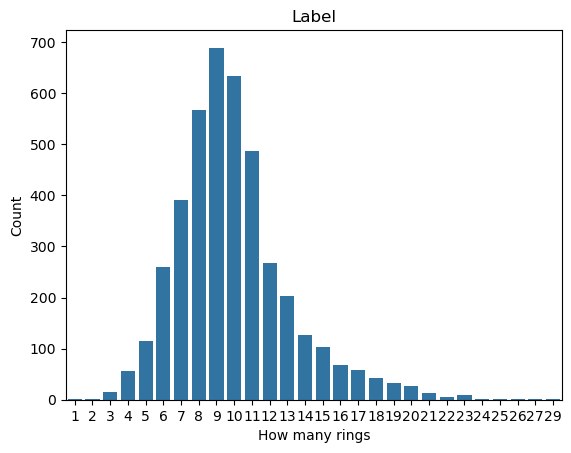

In [47]:
# 레이블 갯수 확인 (그래프)
sns.countplot(data = df, x="Rings")
plt.xlabel("How many rings")
plt.ylabel("Count")
plt.title("Label")

In [49]:
# 결측치 확인
(df == 0).sum()

Sex               0
Length            0
Diameter          0
Height            2
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [51]:
# 결측치 제거
# Outcome 열을 제외한 나머지 열에서 0이 포함된 행을 제거
df = df[(df!= 0).all(axis=1)]

# 결과 출력
print(df.shape)  # 0 값이 제거된 후의 데이터 크기 확인

(4175, 9)


In [53]:
# Sex 값을 F -> 0, M -> 1로 변환
df['Sex'] = df['Sex'].replace({'F': 0, 'M': 1, 'I':2})

/var/folders/nr/9d9y7mfn50b3sc_ncv28vstc0000gn/T/ipykernel_18679/377919716.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Sex'] = df['Sex'].replace({'F': 0, 'M': 1, 'I':2})
/var/folders/nr/9d9y7mfn50b3sc_ncv28vstc0000gn/T/ipykernel_18679/377919716.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sex'] = df['Sex'].replace({'F': 0, 'M': 1, 'I':2})


In [55]:
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,1,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,1,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,0,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,1,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,1,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9


In [57]:
X = df.drop('Rings', axis=1).values
y = df['Rings'].values

# 타겟 정규화 (MinMaxScaler 사용)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 특성 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 입력 데이터 차원 변경 (Conv1D에 맞게)
X_train = X_train[:, :, np.newaxis]  # (샘플 수, 피처 수, 1)
X_test = X_test[:, :, np.newaxis]

# CNN 모델 구축 (회귀용)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))  # 중간 Dense 레이어
model.add(Dense(1, activation='linear'))  # 출력 레이어, 회귀를 위한 'linear' 활성화 함수

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [91]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9496 - mae: 1.6195 - val_loss: 4.4651 - val_mae: 1.4917
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2721 - mae: 1.6364 - val_loss: 4.5399 - val_mae: 1.6382
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0749 - mae: 1.6195 - val_loss: 4.3230 - val_mae: 1.5775
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8413 - mae: 1.5706 - val_loss: 4.2752 - val_mae: 1.5078
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9257 - mae: 1.6062 - val_loss: 4.1459 - val_mae: 1.5166
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4921 - mae: 1.5542 - val_loss: 4.2080 - val_mae: 1.5171
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8549 - mae: 1.6028 - val_loss: 4.2762 - val_mae: 1.5271
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7910 - mae: 1.6090 - val_loss: 4.2798 - val_mae: 1.5172
Epoch 9/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4257 - mae: 

In [88]:
# 모델 평가
loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test MAE: {mae}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - loss: 5.6909 - mae: 1.6025
Test Loss: 5.178070545196533, Test MAE: 1.5616470575332642
